In [1]:
import os, pickle, copy, sys
os.chdir(os.path.expanduser(os.path.join("~", "Projects", "zimmer")))

import numpy as np
np.random.seed(1234)

# Plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
import matplotlib.animation as manimation
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable

from hips.plotting.colormaps import gradient_cmap
from hips.plotting.sausage import sausage_plot
from hips.plotting.layout import create_axis_at_location

# Come up with a set of colors
import seaborn as sns
sns.set_style("white")
# sns.set_context("paper")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

%matplotlib inline

# Modeling stuff
import importlib
from sklearn.decomposition import PCA

from pybasicbayes.distributions import Gaussian, Regression, DiagonalRegression
from pybasicbayes.util.text import progprint_xrange
from pyhsmm.util.general import relabel_by_usage, relabel_by_permutation
from pyslds.util import get_empirical_ar_params

# Load basic pyslds models
from pyslds.models import HMMSLDS, WeakLimitStickyHDPHMMSLDS

# Load worm modeling specific stuff
import zimmer.io
importlib.reload(zimmer.io)
from zimmer.io import WormData, find_shared_neurons, load_key

import zimmer.states
importlib.reload(zimmer.states)

import zimmer.models
importlib.reload(zimmer.models)
from zimmer.models import HierarchicalWeakLimitStickyHDPHMMSLDS, HierarchicalRecurrentSLDS, HierarchicalRecurrentOnlySLDS
from zimmer.emissions import HierarchicalDiagonalRegression

import zimmer.plotting
importlib.reload(zimmer.plotting)
from zimmer.plotting import plot_1d_continuous_states, plot_3d_continuous_states, plot_vector_field_3d, \
    plot_discrete_state_samples, plot_changepoint_prs, make_states_3d_movie, plot_3d_dynamics, \
    make_states_dynamics_movie, plot_transition_matrix

from zimmer.util import states_to_changepoints

In [13]:
# IO
run_num = 1
results_dir = os.path.join("results", "2017-11-03-arhmm", "run{:03d}".format(run_num))
assert os.path.exists(results_dir)

# Specify the signal to model
signal = "dff_diff"

# Hyperparameters
Kmax = 15      # number of latent discrete states
D_latent = 15  # latent linear dynamics' dimension
D_in = 1       # number of input dimensions
D_obs = 60

alpha = 3.     # Transition matrix concentration
gamma = 3.0    # Base state concentration
kappa = 100.   # Stickiness parameter

alpha_0 = 1.0  # Gamma prior for emission variance
beta_0 = 1.0  # Gamma prior for emission variance

# Number of worms to fit
N_worms = 5

In [14]:
# Load the data
worm_datas = [WormData(i, name="worm{}".format(i)) for i in range(N_worms)]
Ns = np.array([wd.N for wd in worm_datas])
Ts = np.array([wd.T for wd in worm_datas])
Ys = [getattr(wd, signal) for wd in worm_datas]

if signal == "dff_deriv":
    Ys = [Y * 10 for Y in Ys]

# Get the "true" discrete states as labeled by Zimmer
z_trues = [wd.zimmer_states for wd in worm_datas]
perm_z_trues, newlabels = relabel_by_usage(z_trues, return_mapping=True)
z_trues = perm_z_trues

# Get the key
z_key = load_key()
perm_z_key = [z_key[i] for i in np.argsort(newlabels)]
z_key = perm_z_key

# Get the names of the neurons
all_neuron_names = np.unique(np.concatenate([wd.neuron_names for wd in worm_datas]))
N_neurons = all_neuron_names.size
print("{} neurons across all {} worms".format(N_neurons, N_worms))

# Find the shared neurons
shared_neurons = find_shared_neurons(worm_datas)
print("{} shared neurons".format(len(shared_neurons)))
Ys_shared = []
for wd, Y in zip(worm_datas, Ys):
    shared_indices = wd.find_neuron_indices(shared_neurons)
    Ys_shared.append(Y[:, shared_indices])

# Construct a big dataset with all neurons for each worm
datasets = []
data_masks = []
for wd in worm_datas:
    this_dataset = np.zeros((wd.T, N_neurons))
    this_mask = np.zeros((wd.T, N_neurons), dtype=bool)
    indices = wd.find_neuron_indices(all_neuron_names)
    for n, index in enumerate(indices):
        if index is not None:
            this_dataset[:,n] = getattr(wd, signal)[:, index]
            this_mask[:,n] = True

    datasets.append(this_dataset)
    data_masks.append(this_mask)

477 neurons across all 5 worms
Potentially shared neurons:
 ['---' 'AIBL' 'AIBR' 'ALA' 'AVAL' 'AVAR' 'AVBL' 'AVBR' 'AVER' 'RIBL' 'RID'
 'RIML' 'RIMR' 'RIVL' 'RIVR' 'RMED' 'RMEL' 'RMER' 'SMDVR' 'VB01' 'VB02']
Found 15 truly shared neurons:
['AIBL', 'AIBR', 'ALA', 'AVAL', 'AVAR', 'AVBL', 'AVER', 'RID', 'RIML', 'RIMR', 'RMED', 'RMEL', 'RMER', 'VB01', 'VB02']
15 shared neurons


In [33]:
def make_lds_parameters(D_latent):
    init_dynamics_distns = [
        Gaussian(
            mu=np.zeros(D_latent),
            sigma=3*np.eye(D_latent),
            nu_0=D_latent + 2, sigma_0=3. * np.eye(D_latent),
            mu_0=np.zeros(D_latent), kappa_0=1.0,
        )
        for _ in range(Kmax)]

    # dynamics_hypparams = get_empirical_ar_params(
    #     [np.hstack((np.vstack(pca_trajs)[:,:P], np.ones((sum(Ts), 1))))],
    #     dynamics_hypparams)

    As = [np.hstack((0.99 * np.eye(D_latent), np.zeros((D_latent, D_in)))) for _ in range(Kmax)]
    dynamics_distns = [
        Regression(
            A=As[k],
            sigma=0.1 * np.eye(D_latent),
            nu_0=D_latent + D_in + 2,
            S_0=0.1 * np.eye(D_latent),
            M_0=np.hstack((np.eye(D_latent), np.zeros((D_latent, D_in)))),
            K_0=np.eye(D_latent + D_in),
        )
        for k in range(Kmax)]

    emission_distns = \
        DiagonalRegression(
            D_obs, D_latent + D_in,
            alpha_0=alpha_0, beta_0=beta_0)

    return init_dynamics_distns, dynamics_distns, emission_distns

In [34]:
def _fit_lds(x_inits, ys, masks, N_gibbs=500):
    print("Fitting standard LDS")
    init_dynamics_distns, dynamics_distns, emission_distns = \
        make_slds_parameters()
        
    x_inits = [None] * len(ys) if x_inits is None else x_inits
    
    # LDS is a switching LDS with one state
    lds = HMMSLDS(
        init_dynamics_distns=init_dynamics_distns[:1],
        dynamics_distns=dynamics_distns[:1],
        emission_distns=emission_distns,
        alpha=alpha,
        init_state_distn='uniform')
    
    # Add the data
    for y, mask, xi in zip(ys, masks, x_inits):
        T = y.shape[0]
        inputs = np.ones((T, D_in))
        lds.add_data(data=y, mask=mask, inputs=inputs)

        # Initialize continuous latent states
        if xi is not None:
            lds.states_list[-1].gaussian_states = xi[:, :D_latent]

    # Resample parameters once to be consistent with x_init
    lds.resample_parameters()
    
    # Fit the model with MCMC
    def evaluate(model):
        ll = model.log_likelihood()
        return ll

    def update_gibbs(model, itr):
        model.resample_model()
        if itr % 25 == 0:
            print(abs(model.states_list[0].gaussian_states).max())
        return evaluate(model)
    
    lls  = [update_gibbs(lds, itr) for itr in progprint_xrange(N_gibbs)]
    lls = np.array(lls)

    # Compute the smoothed continuous state trajectories
    for states in lds.states_list:
        states.info_E_step()
    x_finals = [s.smoothed_mus for s in lds.states_list]
    sigma_x_finals = [s.smoothed_sigmas for s in lds.states_list]

    return lds, lls, x_finals, sigma_x_finals

Fitting standard LDS
1.95859683183
.........................  [  25/500,    0.15sec avg, ETA 01:13 ]
4.78346310904
.........................  [  50/500,    0.15sec avg, ETA 01:09 ]
4.66010080274
.........................  [  75/500,    0.15sec avg, ETA 01:05 ]
4.9353522941
.........................  [ 100/500,    0.15sec avg, ETA 01:02 ]
4.40777536524
.........................  [ 125/500,    0.16sec avg, ETA 58.40 ]
4.66430819742
.........................  [ 150/500,    0.16sec avg, ETA 55.44 ]
4.21928756635
.........................  [ 175/500,    0.16sec avg, ETA 52.10 ]
3.86507615001
.........................  [ 200/500,    0.17sec avg, ETA 49.70 ]
4.34753691595
.........................  [ 225/500,    0.16sec avg, ETA 45.30 ]
3.8041597045
.........................  [ 250/500,    0.16sec avg, ETA 40.77 ]
3.77220374453
.........................  [ 275/500,    0.16sec avg, ETA 36.61 ]
3.60783191561
.........................  [ 300/500,    0.16sec avg, ETA 32.85 ]
3.73156171525
.......

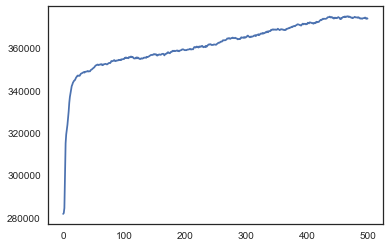

In [39]:
# Fit an LDS to all the data
# fit_joint_lds = cached("lds_joint")(_fit_lds)
fit_joint_lds = _fit_lds
lds, lds_lls, lds_x_finals, lds_sigma_x_finals = \
        fit_joint_lds(x_inits=[0.5 * np.random.randn(T, D_latent) for T in Ts], 
                      ys=[y[:,:D_obs] for y in datasets], 
                      masks=[m[:,:D_obs] for m in data_masks], 
                      N_gibbs=500)
    
plt.plot(lds_lls)

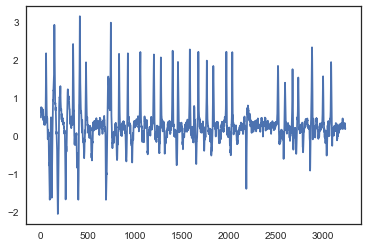

In [40]:
plt.plot(lds_x_finals[0][:,0])

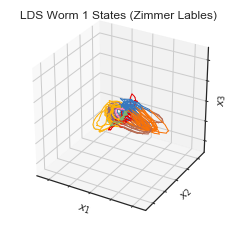

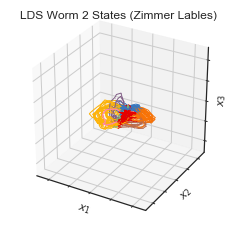

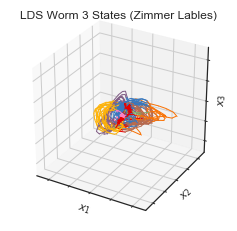

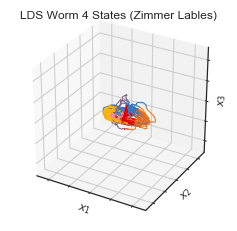

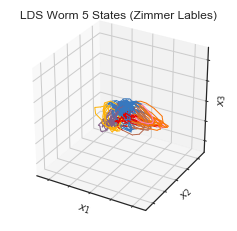

In [42]:
# False color with the "true" label from Zimmer
for worm in range(N_worms):
    plot_3d_continuous_states(lds_x_finals[worm], z_trues[worm], colors,
                              figsize=(4, 4),
                              title="LDS Worm {} States (Zimmer Lables)".format(worm + 1),
                              results_dir=results_dir,
#                               filename="lds_x_worm_zimmer_{}.pdf".format(worm + 1),
                              lim=5,
                              lw=1)